# diffusion model

![fig](../assets/DDPM.png)

## forward process

In [1]:
"""
mean = sqrt(a_hat)*x_0
variance = sqrt(1-a_hat) * random_noise
"""

'\nmean = sqrt(a_hat)*x_0\nvariance = sqrt(1-a_hat) * random_noise\n'

In [2]:
import torch
from torchvision import transforms

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
# define starting input
x0 = torch.randn(2,3,32,32)
x0.shape

torch.Size([2, 3, 32, 32])

In [5]:
# define variance scheduler betas
betas = torch.tensor([0.05,0.1,0.15,0.2,0.25])
betas

tensor([0.0500, 0.1000, 0.1500, 0.2000, 0.2500])

In [6]:
# define timestep
t = torch.tensor([1,3])
t

tensor([1, 3])

In [7]:
# betas -> the amount of noise that are being applied at every timstep of diffusion process
# alphas -> 1-betas --> amount of original image's information that are being preserved affer a diffusion process step
alphas = 1 - betas
alphas

tensor([0.9500, 0.9000, 0.8500, 0.8000, 0.7500])

In [8]:
alpha_hat = torch.cumprod(alphas,axis=0)
alpha_hat

tensor([0.9500, 0.8550, 0.7268, 0.5814, 0.4360])

In [9]:
# get correctsponing alpha_hat by timestep, this case first value, third value
alpha_hat_t = alpha_hat.gather(-1,t)

# reshape the result for multiply with input
alpha_hat_t = alpha_hat_t.reshape(-1,1,1,1)

In [10]:
# noise is tensor is the same shape of x_0, the value is gaussian distribution
noise = torch.rand_like(x0)
noise.shape

torch.Size([2, 3, 32, 32])

In [11]:
mean = alpha_hat_t.sqrt() * x0
variance = torch.sqrt(1-alpha_hat_t) *noise
print('mean',mean.shape)
print('variance',variance.shape)

mean torch.Size([2, 3, 32, 32])
variance torch.Size([2, 3, 32, 32])


In [12]:
# x_t is 2 image at the timestep t=1,3 which less noise and which more noise
x_t = mean + variance

In [13]:
x_t[1]

tensor([[[ 0.1001, -0.9600, -0.4245,  ...,  0.8829,  1.2522, -0.4409],
         [ 0.3868, -1.6497,  0.8241,  ..., -0.5142,  1.3241,  0.8471],
         [ 2.0517,  0.3051, -0.9465,  ...,  0.0691, -1.2102, -1.1358],
         ...,
         [ 1.4545,  0.6516,  0.4061,  ...,  1.1704,  0.1330,  1.9000],
         [ 0.8539, -1.5552,  1.1397,  ...,  0.1049, -0.4431,  1.1833],
         [-0.2244, -0.1125,  1.4142,  ...,  0.9544,  0.5218,  0.5261]],

        [[ 0.5657,  1.1788, -0.5299,  ..., -0.0969,  0.6387, -0.2920],
         [ 0.7904, -0.1841, -0.2322,  ...,  0.9119,  1.1332, -0.4209],
         [ 0.3384,  0.6118,  0.0087,  ...,  0.9289,  0.4544, -0.3345],
         ...,
         [ 0.5865, -0.2035,  0.4914,  ..., -1.8654,  1.6814,  0.9481],
         [ 1.4526,  0.6876, -0.3074,  ...,  1.0642,  0.9752, -1.7796],
         [-0.5346,  0.9848,  0.1909,  ..., -0.7248,  0.1129, -0.4358]],

        [[ 0.3864,  0.6947,  0.6687,  ...,  0.4133,  0.8447,  1.0392],
         [ 1.5562,  0.7494,  0.2895,  ..., -0

In [14]:
# define function forward_diffusion
def forward_diffusion(x0,t,betas=torch.linspace(0.0,1.0,5)):
    noise = torch.rand_like(x0) # random tensor with values sampled from N(0,1)
    alphas = 1 - betas
    alpha_hat = torch.cumprod(alphas,axis=0)
    alpha_hat_t = alpha_hat.gather(-1,t).reshape(-1,1,1,1)
    mean = alpha_hat_t.sqrt() * x0
    variance = torch.sqrt(1-alpha_hat_t) *noise
    return mean + variance, noise

In [15]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

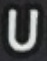

In [23]:
# random choice input image
filenames = os.listdir('../data')
filename = random.choice(filenames)

# show image
image = Image.open(os.path.join('../data',filename))
image

In [24]:
IMAGE_SHAPE = (32,32)
transform = transforms.Compose([
    transforms.Resize(IMAGE_SHAPE), # Resize the input image
    transforms.ToTensor(), # Convert to torch tensor (scales data into [0,1])
    transforms.Lambda(lambda t: (t * 2) - 1), # Scale data between [-1, 1] 
])


reverse_transform = transforms.Compose([
    transforms.Lambda(lambda t: (t + 1) / 2), # Scale data between [0,1]
    transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
    transforms.Lambda(lambda t: t * 255.), # Scale data between [0.,255.]
    transforms.Lambda(lambda t: t.cpu().numpy().astype(np.uint8)), # Convert into an uint8 numpy array
    transforms.ToPILImage(), # Convert to PIL image
])

In [25]:
# test transform function
torch_image = transform(image)
torch_image.shape

torch.Size([3, 32, 32])

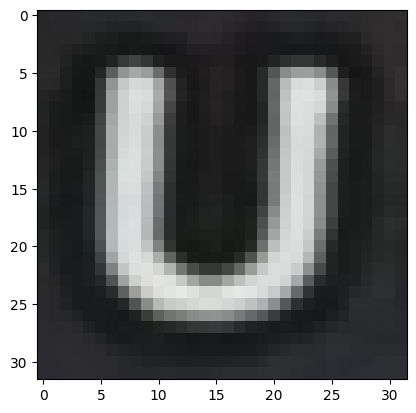

In [26]:
# test reverse transform function
plt.imshow(reverse_transform(torch_image))

In [27]:
t = torch.tensor([0,1,2,3,4]) # batch of 5 t value
batch_images  = torch.stack([torch_image] * t.size()[0]) # batch of 5 image
noisy_images,_ = forward_diffusion(batch_images,t)

noisy_images.size()

torch.Size([5, 3, 32, 32])

torch.Size([3, 32, 32])


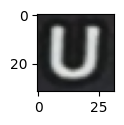

torch.Size([3, 32, 32])


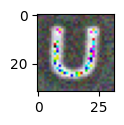

torch.Size([3, 32, 32])


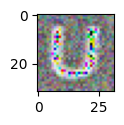

torch.Size([3, 32, 32])


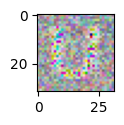

torch.Size([3, 32, 32])


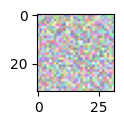

In [28]:
for img in noisy_images:
    print(img.size())
    plt.figure(figsize=(1,1))
    plt.imshow(reverse_transform(img))
    plt.show()

In [29]:
def plot_forward_diffusion(noisy_images):
    plt.figure(figsize=(15,15))
    f, ax = plt.subplots(1, noisy_images.size()[0], figsize = (100,100))
    
    for idx, image in enumerate(noisy_images):
        ax[idx].imshow(reverse_transform(image))
        ax[idx].set_title(f"Iteration: {t[idx].item()}", fontsize = 100)
    plt.show() 

<Figure size 1500x1500 with 0 Axes>

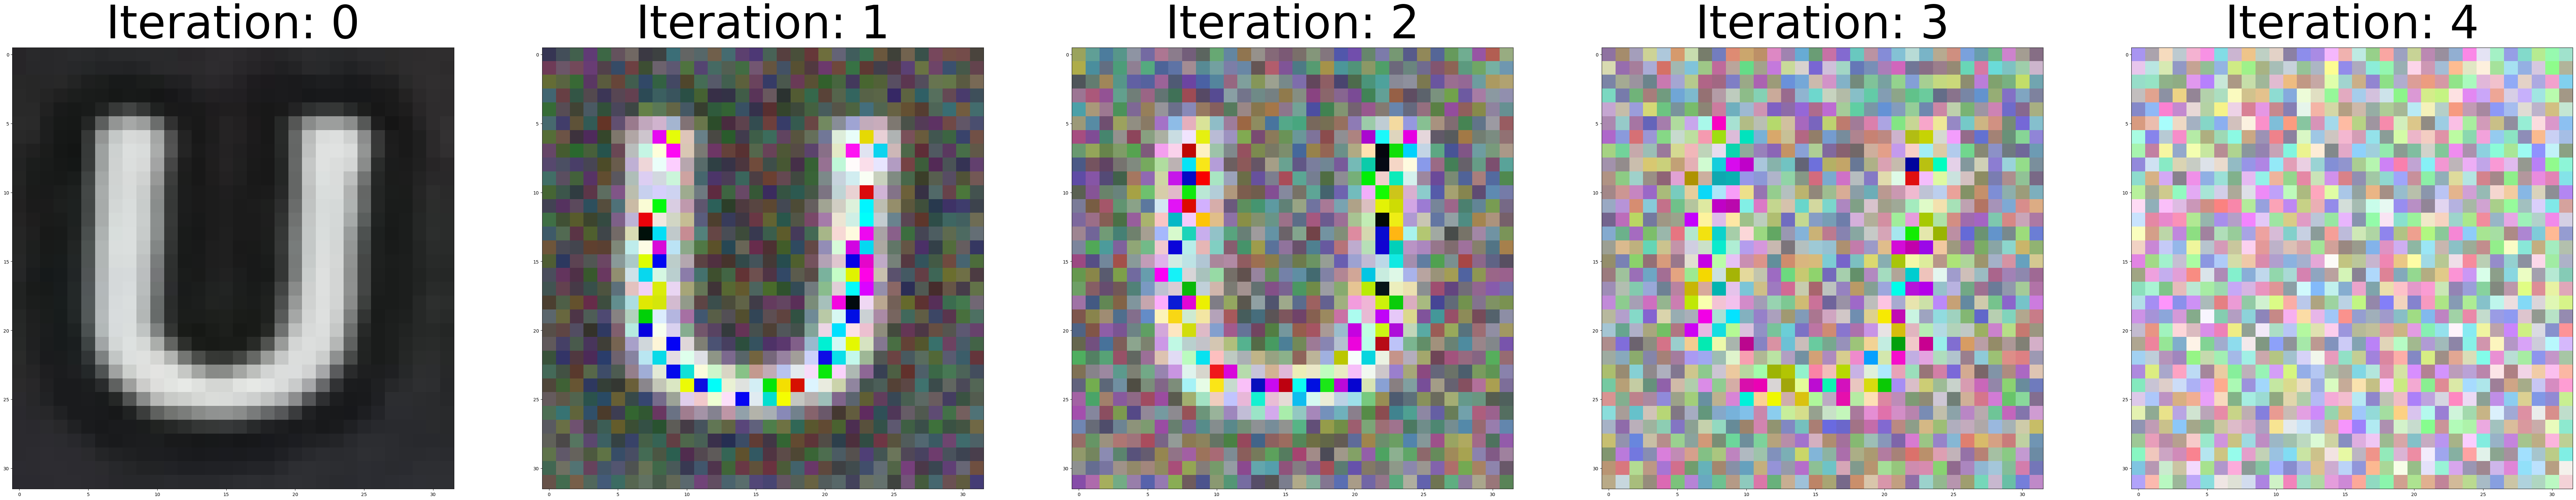

In [30]:
plot_forward_diffusion(noisy_images)

In [31]:
class DiffusionModel:
    def __init__(self, start_schedule=0.0001, end_schedule=0.02, timesteps = 300):
        self.start_schedule = start_schedule
        self.end_schedule = end_schedule
        self.timesteps = timesteps
        
        """
        if 
            betas = [0.1, 0.2, 0.3, ...]
        then
            alphas = [0.9, 0.8, 0.7, ...]
            alphas_cumprod = [0.9, 0.9 * 0.8, 0.9 * 0.8, * 0.7, ...]
            
        
        """ 
        self.betas = torch.linspace(start_schedule, end_schedule, timesteps)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        
    def forward(self, x_0, t, device):
        """
        x_0: (B, C, H, W)
        t: (B,)
        """
        noise = torch.randn_like(x_0)
        sqrt_alphas_cumprod_t = self.get_index_from_list(self.alphas_cumprod.sqrt(), t, x_0.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x_0.shape)
            
        mean = sqrt_alphas_cumprod_t.to(device) * x_0.to(device)
        variance = sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device)
        
        return mean + variance, noise.to(device)
    
    @torch.no_grad()
    def backward(self, x, t, model, **kwargs):
        """
        Calls the model to predict the noise in the image and returns 
        the denoised image. 
        Applies noise to this image, if we are not in the last step yet.
        """
        betas_t = self.get_index_from_list(self.betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x.shape)
        sqrt_recip_alphas_t = self.get_index_from_list(torch.sqrt(1.0 / self.alphas), t, x.shape)
        mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t, **kwargs) / sqrt_one_minus_alphas_cumprod_t)
        posterior_variance_t = betas_t

        if t == 0:
            return mean
        else:
            noise = torch.randn_like(x)
            variance = torch.sqrt(posterior_variance_t) * noise 
            return mean + variance

    @staticmethod
    def get_index_from_list(values, t, x_shape):
        batch_size = t.shape[0]
        """
        pick the values from vals
        according to the indices stored in `t`
        """
        result = values.gather(-1, t.cpu())
        """
        if 
        x_shape = (5, 3, 64, 64)
            -> len(x_shape) = 4
            -> len(x_shape) - 1 = 3
            
        and thus we reshape `out` to dims
        (batch_size, 1, 1, 1)
        
        """
        return result.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [32]:
# predict model
torch.cuda.empty_cache()

diffusion_model = DiffusionModel()

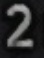

In [33]:
# get random image
filename = random.choice(filenames)
pil_image = Image.open(os.path.join('../data',filename))
torch_image = transform(pil_image)
pil_image

<Figure size 1500x1500 with 0 Axes>

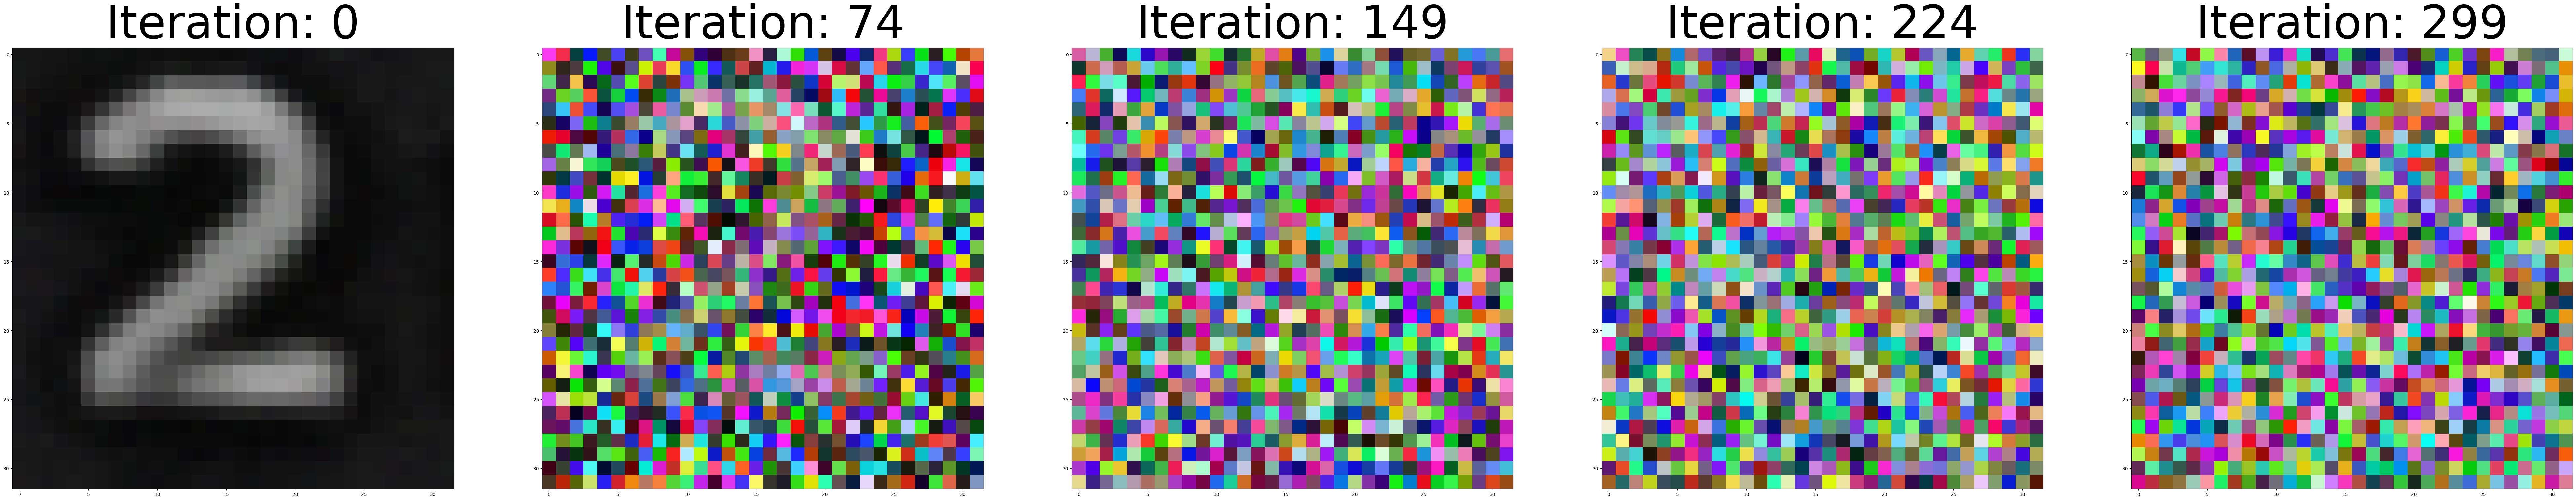

In [34]:
NO_DISPLAY_IMAGES = 5
torch_image_batch = torch.stack([torch_image] * NO_DISPLAY_IMAGES)
t = torch.linspace(0, diffusion_model.timesteps - 1, NO_DISPLAY_IMAGES).long()
noisy_image_batch, _ = diffusion_model.forward(torch_image_batch, t, device)

plot_forward_diffusion(noisy_image_batch)

## training

In [35]:
import math
import torch.nn as nn

In [36]:
# definw Unet model
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class Block(nn.Module):
    def __init__(self, channels_in, channels_out, time_embedding_dims, labels, num_filters = 3, downsample=True):
        super().__init__()
        
        self.time_embedding_dims = time_embedding_dims
        self.time_embedding = SinusoidalPositionEmbeddings(time_embedding_dims)
        self.labels = labels
        if labels:
            self.label_mlp = nn.Linear(1, channels_out)
        
        self.downsample = downsample
        
        if downsample:
            self.conv1 = nn.Conv2d(channels_in, channels_out, num_filters, padding=1)
            self.final = nn.Conv2d(channels_out, channels_out, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(2 * channels_in, channels_out, num_filters, padding=1)
            self.final = nn.ConvTranspose2d(channels_out, channels_out, 4, 2, 1)
            
        self.bnorm1 = nn.BatchNorm2d(channels_out)
        self.bnorm2 = nn.BatchNorm2d(channels_out)
        
        self.conv2 = nn.Conv2d(channels_out, channels_out, 3, padding=1)
        self.time_mlp = nn.Linear(time_embedding_dims, channels_out)
        self.relu = nn.ReLU()

    def forward(self, x, t, **kwargs):
        o = self.bnorm1(self.relu(self.conv1(x)))
        o_time = self.relu(self.time_mlp(self.time_embedding(t)))
        o = o + o_time[(..., ) + (None, ) * 2]
        if self.labels:
            label = kwargs.get('labels')
            o_label = self.relu(self.label_mlp(label))
            o = o + o_label[(..., ) + (None, ) * 2]
            
        o = self.bnorm2(self.relu(self.conv2(o)))

        return self.final(o)
    
class UNet(nn.Module):
    def __init__(self, img_channels = 3, time_embedding_dims = 128, labels = False, sequence_channels = (64, 128, 256, 512, 1024)):
        super().__init__()
        self.time_embedding_dims = time_embedding_dims
        sequence_channels_rev = reversed(sequence_channels)
        
        self.downsampling = nn.ModuleList([Block(channels_in, channels_out, time_embedding_dims, labels) for channels_in, channels_out in zip(sequence_channels, sequence_channels[1:])])
        self.upsampling = nn.ModuleList([Block(channels_in, channels_out, time_embedding_dims, labels,downsample=False) for channels_in, channels_out in zip(sequence_channels[::-1], sequence_channels[::-1][1:])])
        self.conv1 = nn.Conv2d(img_channels, sequence_channels[0], 3, padding=1)
        self.conv2 = nn.Conv2d(sequence_channels[0], img_channels, 1)

    
    def forward(self, x, t, **kwargs):
        residuals = []
        o = self.conv1(x)
        for ds in self.downsampling:
            o = ds(o, t, **kwargs)
            residuals.append(o)
        for us, res in zip(self.upsampling, reversed(residuals)):
            o = us(torch.cat((o, res), dim=1), t, **kwargs)
            
        return self.conv2(o)

In [37]:
# init hyperparameters
NO_EPOCHS = 800
PRINT_FREQUENCY = 400
LR = 0.001
BATCH_SIZE = 5
VERBOSE = True

In [38]:
# instance of Unet class
unet = UNet(labels=None)
unet.to(device)
unet

UNet(
  (downsampling): ModuleList(
    (0): Block(
      (time_embedding): SinusoidalPositionEmbeddings()
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (final): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (time_mlp): Linear(in_features=128, out_features=128, bias=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_embedding): SinusoidalPositionEmbeddings()
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (final): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (bnorm1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): Bat

In [39]:
optimizer = torch.optim.Adam(unet.parameters(), lr=LR)

In [40]:
def plot_noise_distribution(noise, predicted_noise):
    plt.hist(noise.cpu().numpy().flatten(), density = True, alpha = 0.8, label = "ground truth noise")
    plt.hist(predicted_noise.cpu().numpy().flatten(), density = True, alpha = 0.8, label = "predicted noise")
    plt.legend()
    plt.show()

In [41]:
def plot_noise_prediction(noise, predicted_noise):
    plt.figure(figsize=(15,15))
    f, ax = plt.subplots(1, 2, figsize = (5,5))
    ax[0].imshow(reverse_transform(noise))
    ax[0].set_title(f"ground truth noise", fontsize = 10)
    ax[1].imshow(reverse_transform(predicted_noise))
    ax[1].set_title(f"predicted noise", fontsize = 10)
    plt.show()

---
Epoch: 0 | Train Loss 1.0121489763259888


<Figure size 1500x1500 with 0 Axes>

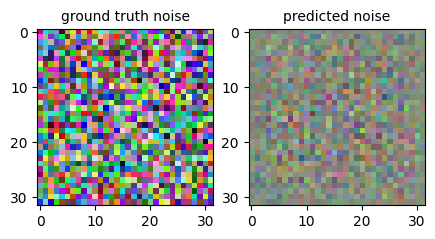

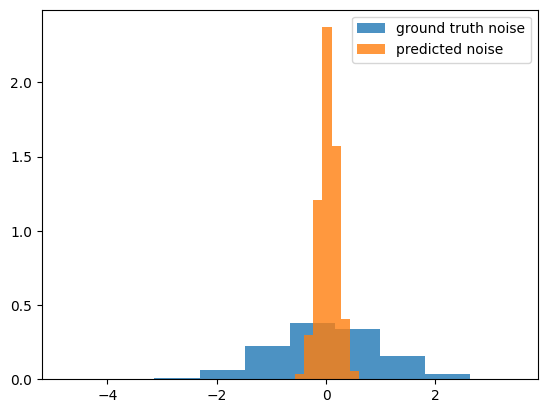

---
Epoch: 400 | Train Loss 0.028703754767775536


<Figure size 1500x1500 with 0 Axes>

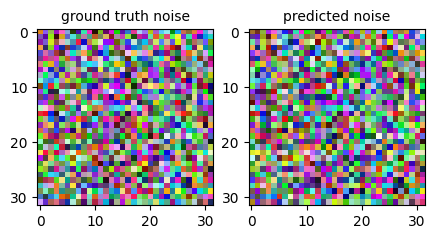

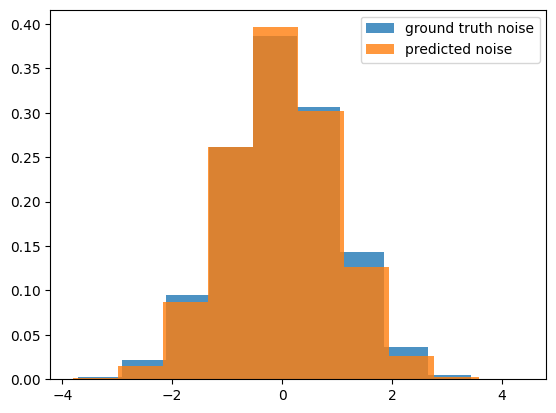

---
Epoch: 800 | Train Loss 0.020687730982899666


<Figure size 1500x1500 with 0 Axes>

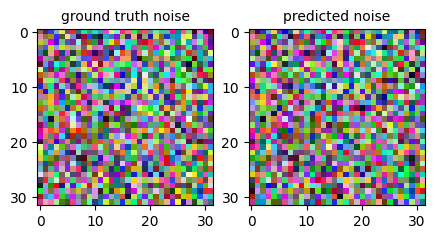

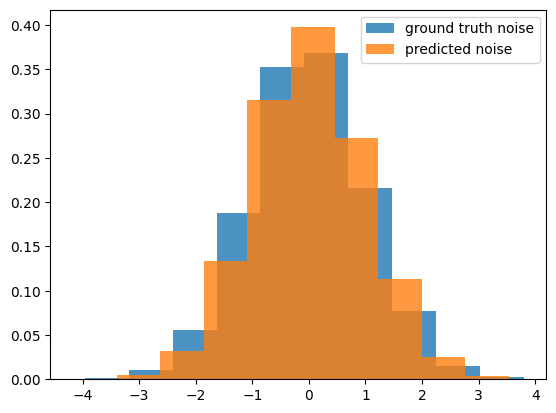

---
Epoch: 1200 | Train Loss 0.019415054470300674


<Figure size 1500x1500 with 0 Axes>

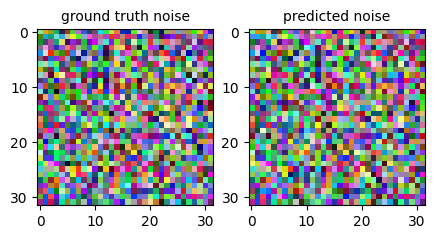

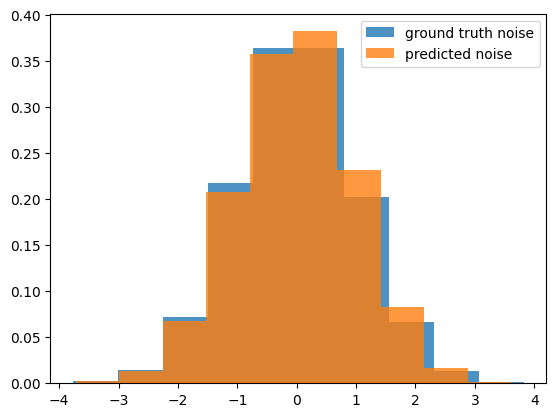

---
Epoch: 1600 | Train Loss 0.020803876221179962


<Figure size 1500x1500 with 0 Axes>

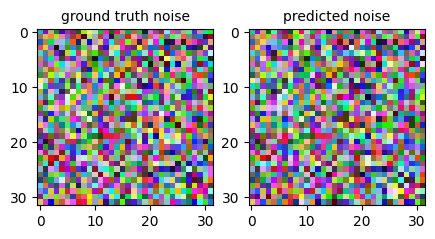

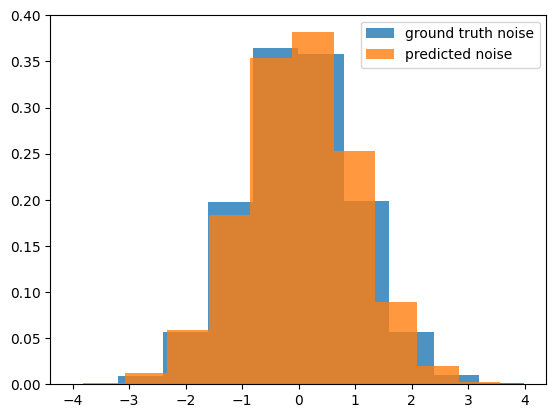

In [42]:
for epoch in range(NO_EPOCHS):
    mean_epoch_loss = []
    
    # generate batch training input
    batch = torch.stack([torch_image] * BATCH_SIZE)
    t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device)
    
    # forward diffusion
    batch_noisy, noise = diffusion_model.forward(batch, t, device) 
    
    #predict noise
    predicted_noise = unet(batch_noisy, t)
    
    # optimize Unet model
    optimizer.zero_grad()
    loss = torch.nn.functional.mse_loss(noise, predicted_noise) 
    mean_epoch_loss.append(loss.item())
    loss.backward()
    optimizer.step()
    
    if epoch % PRINT_FREQUENCY == 0:
        print('---')
        print(f"Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss)}")
        if VERBOSE:
            with torch.no_grad():
                plot_noise_prediction(noise[0], predicted_noise[0])
                plot_noise_distribution(noise, predicted_noise)

<Figure size 1500x1500 with 0 Axes>

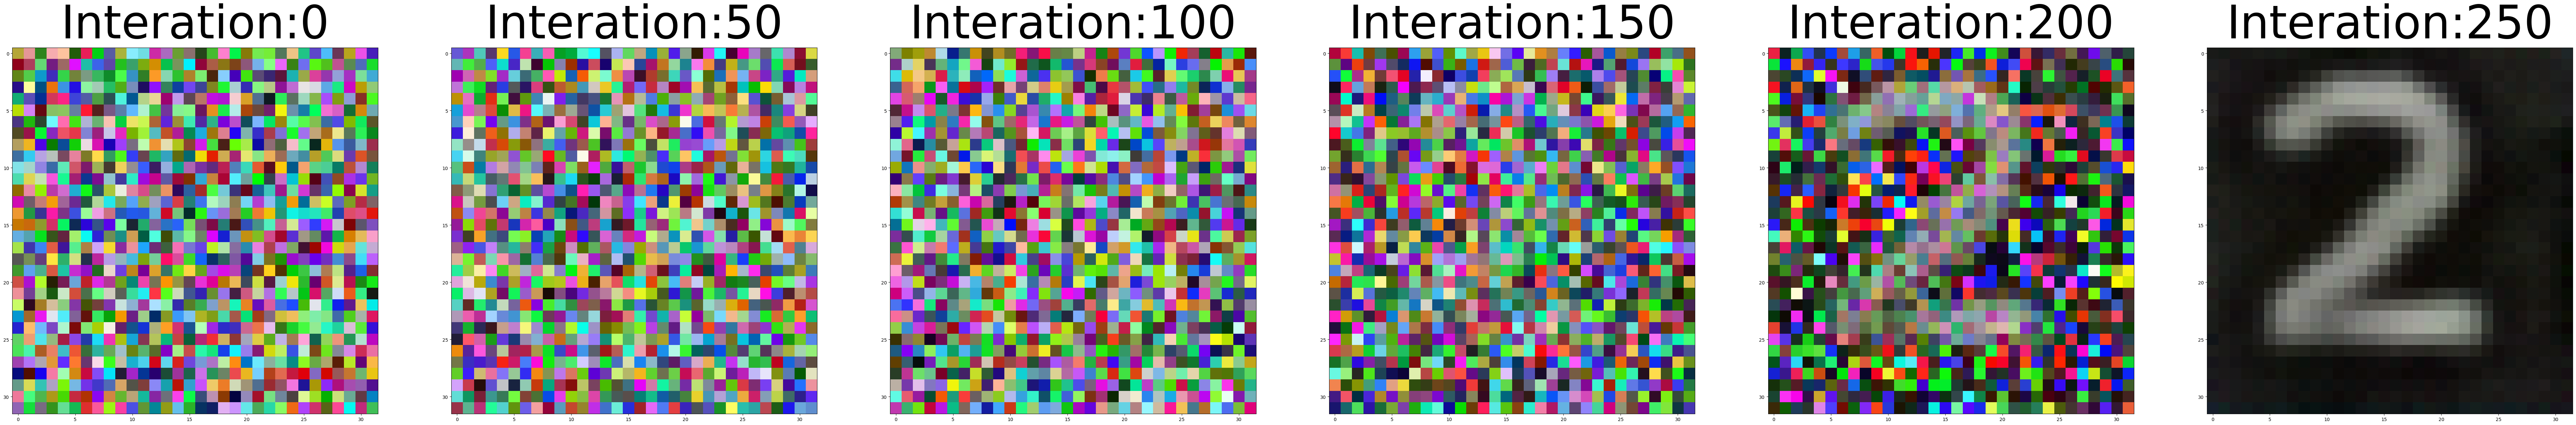

In [72]:
DISPLAY_STEP = 50
NO_FIGURES = diffusion_model.timesteps // DISPLAY_STEP
denoise_images = []

# Denoise
with torch.no_grad():
    img = torch.randn((1, 3) + IMAGE_SHAPE).to(device)
    for i in reversed(range(diffusion_model.timesteps)):
        t = torch.full((1,), i, dtype=torch.long, device=device)
        img = diffusion_model.backward(img, t, unet.eval())
        if i % DISPLAY_STEP == 0:
            denoise_images.append(img[0])

# Display
plt.figure(figsize=(15,15))
f, ax = plt.subplots(1, NO_FIGURES, figsize = (100,100))

for idx, image in enumerate(denoise_images):
    ax[idx].imshow(reverse_transform(image))
    ax[idx].set_title(f"Interation:{idx*DISPLAY_STEP}", fontsize = 100)
plt.show()

# training with cifar10 dataset

In [74]:
import torchvision

In [75]:
BATCH_SIZE = 256
NO_EPOCHS = 100
PRINT_FREQUENCY = 10
LR = 0.001
VERBOSE = False

In [76]:
unet = UNet(labels=True)
unet.to(device)
optimizer = torch.optim.Adam(unet.parameters(), lr=LR)

In [77]:
trainset = torchvision.datasets.CIFAR10(root='./cifar10', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, drop_last=True)

testset = torchvision.datasets.CIFAR10(root='./cifar10', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8, drop_last=True)

100%|█████████████████████████| 170498071/170498071 [03:59<00:00, 711696.64it/s]


Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10
Files already downloaded and verified


In [78]:
for epoch in range(NO_EPOCHS):
    mean_epoch_loss = []
    mean_epoch_loss_val = []
    for batch, label in trainloader:
        t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device)
        batch = batch.to(device)
        batch_noisy, noise = diffusion_model.forward(batch, t, device) 
        predicted_noise = unet(batch_noisy, t, labels = label.reshape(-1,1).float().to(device))

        optimizer.zero_grad()
        loss = torch.nn.functional.mse_loss(noise, predicted_noise) 
        mean_epoch_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
    for batch, label in testloader:

        t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device)
        batch = batch.to(device)

        batch_noisy, noise = diffusion_model.forward(batch, t, device) 
        predicted_noise = unet(batch_noisy, t, labels = label.reshape(-1,1).float().to(device))

        loss = torch.nn.functional.mse_loss(noise, predicted_noise) 
        mean_epoch_loss_val.append(loss.item())

    if epoch % PRINT_FREQUENCY == 0:
        print('---')
        print(f"Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss)} | Val Loss {np.mean(mean_epoch_loss_val)}")
        if VERBOSE:
            with torch.no_grad():
                plot_noise_prediction(noise[0], predicted_noise[0])
                plot_noise_distribution(noise, predicted_noise)
                
        torch.save(unet.state_dict(), f"epoch: {epoch}")

---
Epoch: 0 | Train Loss 0.17979046690922518 | Val Loss 0.08993067133885163
---
Epoch: 10 | Train Loss 0.06960812247334383 | Val Loss 0.06998071189110096
---
Epoch: 20 | Train Loss 0.06620601255160112 | Val Loss 0.06620454549407348
---
Epoch: 30 | Train Loss 0.0633216003767955 | Val Loss 0.06357557125962697
---
Epoch: 40 | Train Loss 0.06277655829221775 | Val Loss 0.06235789173306563
---
Epoch: 50 | Train Loss 0.06236053290657508 | Val Loss 0.061719036828248926
---
Epoch: 60 | Train Loss 0.06072106160796606 | Val Loss 0.061021037304248564
---
Epoch: 70 | Train Loss 0.06042559729554714 | Val Loss 0.0604789239855913
---
Epoch: 80 | Train Loss 0.06071059312193822 | Val Loss 0.061180984076016985
---
Epoch: 90 | Train Loss 0.05991615519309655 | Val Loss 0.059861146773283296


In [83]:
unet = UNet(labels=True)
unet.load_state_dict(torch.load(("epoch: 90")))

<All keys matched successfully>

In [84]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [85]:
NUM_CLASSES = len(classes)
NUM_DISPLAY_IMAGES = 5

In [86]:
torch.manual_seed(16)

plt.figure(figsize=(15,15))
f, ax = plt.subplots(NUM_CLASSES, NUM_DISPLAY_IMAGES, figsize = (100,100))

for c in range(NUM_CLASSES):
    imgs = torch.randn((NUM_DISPLAY_IMAGES, 3) + IMAGE_SHAPE).to(device)
    for i in reversed(range(diffusion_model.timesteps)):
        t = torch.full((1,), i, dtype=torch.long, device=device)
        labels = torch.tensor([c] * NUM_DISPLAY_IMAGES).resize(NUM_DISPLAY_IMAGES, 1).float().to(device)
        imgs = diffusion_model.backward(x=imgs, t=t, model=unet.eval().to(device), labels = labels)
    for idx, img in enumerate(imgs):
        ax[c][idx].imshow(reverse_transform(img))
        ax[c][idx].set_title(f"Class: {classes[c]}", fontsize = 100)
        
plt.show()

<Figure size 1500x1500 with 0 Axes>

https://www.youtube.com/watch?v=S_il77Ttrmg

https://github.com/dtransposed/code_videos/blob/main/Diffusion%20Model.ipynb

https://lilianweng.github.io/posts/2021-07-11-diffusion-models/